<a href="https://colab.research.google.com/github/Mike-Pits/ML_MZK/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%A1%D0%BA%D0%BB%D0%B0%D0%B4_5_%D0%90%D1%80%D0%B8%D1%85%D0%B2%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd
import cv2 
from google.colab.patches import cv2_imshow
from copy import deepcopy
from sklearn.neighbors import KDTree

PIXELS_IN_METER = 7
METERS_IN_PIXEL = 1 / PIXELS_IN_METER
SECONDS_IN_FRAME = 1
FRAMES_IN_SECOND = 1 / SECONDS_IN_FRAME
TRUCK_SPEED = 10 / 3.6     # m/s
MOVER_SPEED = 5 / 3.6
LOADER_SPEED = 5 / 3.6
STACKER_SPEED = 2.5 / 3.6
FORKLIFT_SPEED = 3.6 / 3.6

ERRORS = pd.DataFrame(columns=['Error', 'Info'])

# Основа

## Координаты стеллажей

In [ ]:
'''

                (y)
    0----------->
    |
    |
    |
    |
(x) V 



'''

# Координаты стеллажей в метрах:

X = np.array([0, 6, 18,  24,  30,  42,  48,  54,  66,  78,  90,  96, 108, 114, 126, 132]) + 1       # верхний левый угол
Y = np.hstack([np.arange(0.750, 99, 4.5), np.arange(4, 99, 4.5)])
# Y = np.hstack([np.arange(0.50, 99, 4.5), np.arange(4.25, 99, 4.5)])
Y.sort()

column_names = [str(i) for i in range(X[-1]//6 + 1)]
C = (X - 1) // 6                                                # Индексация каждого стеллажа = ряд + колонна (например "F-12")
rack_column_names = [str(C[i]) for i in range(len(C))]
row_names = [chr(i) for i in range(ord('A'), ord('W')+1)]

rack_coordinates = [list(zip(X , [[y]*len(X) for y in Y][i])) for i in range(len(Y))]  # пример того, как не надо писать)
rack_coordinates = np.array(rack_coordinates).reshape(44*16, 2)
rack_coordinates

array([[  1.  ,   0.75],
       [  7.  ,   0.75],
       [ 19.  ,   0.75],
       ...,
       [115.  ,  98.5 ],
       [127.  ,  98.5 ],
       [133.  ,  98.5 ]])

In [ ]:
Xt = np.array([12, 36, 60, 84, 102, 120]) + 1                # координаты стеллажей для временного хранения
Xt = [(x + 1.8, x + 3) for x in Xt]
Xt = np.array(Xt).flatten()
Yt = [3.75 + i * 0.8 for i in range(15)] + [100 - 3.75 - 1 - i * 0.8 for i in range(15)]
Yt.sort()
temp_rack_coordinates = [list(zip(Xt , [[y]*len(Xt) for y in Yt][i])) for i in range(len(Yt))]
temp_rack_coordinates = np.array(temp_rack_coordinates).reshape(30*12, 2)

## Классы палет и стеллажей

In [ ]:
class Product():
    def __init__(self, 	article, sell_by_date=None, vertex_index=None, place=None):
        self.article = article              
        self.sell_by_date = sell_by_date
        self.vertex_index = vertex_index

    def __repr__(self):
        return str(self.article)

In [ ]:
class Pallet():
    '''
    products -      список товаров на паллете
    rack -          ссылка на стеллаж (class Rack)
    column -        номер колонны на стеллжае (0-3)
    tier -          номер яруса (0-4)
    x, y -          абсолютные координаты палеты (координаты стеллажа + относительные координаты)
    DF_PROD -       голобальная таблица со списком всех товаров

    '''
    def __init__(self, 	products=[], rack=None, column=None, tier=None):
        self.products = products              
        self.rack = rack                  
        self.column = column
        self.tier = tier

        if rack and column and tier:
            self.on_rack = True
            self.x = rack.x + 1.6 * self.column
            self.y = rack.y 
        else:
            self.on_rack = False


    def putting_to_rack(self, rack, column, tier):
            self.on_rack = True
            self.rack = rack
            self.column = column
            self.tier = tier
            self.x = rack.x + 1.6 * self.column
            self.y = rack.y     
            for prod in self.products:
                i = prod.index
                r = rack.r
                c = rack.c
                vertex = f'{r}-{c}(p-{column})' 
                DF_PROD.loc[i] = [prod, vertex, (column, tier), prod.sell_by_date]              # global dataframe

    def getting_from_rack(self):
            vertex_index = f'{self.rack.r}-{self.rack.c}(p-{self.column})'
            self.on_rack = False
            self.rack = None
            self.column = None
            self.tier = None
            self.x = None
            self.y = None    

            for prod in self.products:
                i = prod.index
                x = vertex_dict[vertex_index].x
                y = vertex_dict[vertex_index].y
                DF_PROD.loc[i].Vertex = f'Оn going ({x}, {y})'              # global dataframe 


    def __repr__(self):
        return f'[Pallet at ({self.column},{self.tier})]'


In [ ]:
class Rack():
    '''
    Класс стеллажа
    x, y -       координаты стеллажа в метрах
    r, c -       ряд и колонна по длине и ширине склада (индексы стеллажа)
    odevity -    чётность (для ориентировки, с какой стороны подъезжать)
    pallets -    список паллет на стеллаже
    put_pallet - положить паллету на стеллаж
    get_pallet - забрать паллету со стеллажа

    '''
    def __init__(self, x, y, r=None, c=None, od=None):
        self.x = x
        self.y = y
        self.r = r                          # избыточно?
        self.c = c                          # (по [r, c] можно получить индекс соответствующей вершины графа)
        self.od = od
        self.pallets = np.full((4, 5), fill_value=None)


    def put_pallet(self, pallet, column, tier):                     # type(pallete) == __main__.Pallet
        assert column in [0,1,2,3], 'wrong column number'
        assert tier in [0,1,2,3,4], 'wrong tier number'
        assert not(self.pallets[column, tier]), 'the place is occupied'
        assert not(pallet.on_rack), 'pallet, you try to put, is already on rack'
        pallet.putting_to_rack(self, column, tier)
        self.pallets[column, tier] = pallet


    def get_pallet(self, column, tier):
        assert self.pallets[column, tier], 'no pallet'
        pallet = self.pallets[column, tier]
        pallet.getting_from_rack()
        self.pallets[column, tier] = None
        return pallet


    def __repr__(self):
        a = {0: '\'', 1: ''}[self.od]
        return f'Rack {self.r}{a}-{self.c} at ({self.x/PIXELS_IN_METER:.1f}, {self.y/PIXELS_IN_METER:.1f})'

In [ ]:
class Temp_rack():
    def __init__(self, x, y, c, n):
        self.column = c
        self.num = n
        self.pallet = None

    def put_pallet(self, pallet):
        if self.pallet:
            print(f'{self} already has {self.pallet}')
            ERRORS.loc[len(ERRORS)] = [f'{self} already has {self.pallet}', '']
        else:
            self.pallet = pallet

    def get_pallet(self):
        if self.pallet:
            pallet = self.pallet
            pallet.getting_from_rack()
            self.pallet = None
            return pallet
        else:
            print(f'{self} has no pallet')
            ERRORS.loc[len(ERRORS)] = [f'{self} has no pallet', '']

    def __repr__(self):
        return f'Tamp Rack {self.column}-{self.num}'

## Граф

In [ ]:
class Vertex():                              # Вершина графа   
    def __init__(self, name, x=None, y=None):
        self.name = name                        # имя должно быть уникальным, т.к. оно будет использоваться в качестве ключа для словаря содержащего все вершины графа
        self.x = x
        self.y = y

    def set_xy(self, x, y):
        self.x = x
        self.y = y      

    def get_xy(self):
        return self.x, self.y     

    def __repr__(self):
        if self.x and self.y:
            return f'{self.name} at ({self.x:.1f}, {self.y:.1f})'
        else:
            return self.name


class Edge():                               # Ребро графа
    def __init__(self, u, v, weight):       # u, v - Vertex names
        self.u = u
        self.v = v
        self.weight = weight
        self._weight = weight

    def reversed(self):
        return Edge(self.v, self.u, self.weight)

    def orientation(self):
        v = self.v
        u = self.u 

        if u == 'temp':
            return 'o'

        if u[:2] == v[:2]:
            return 'h'
        elif u[-2] == v[-2]:
            return 'v'
        else:
            return 'h'

    def __lt__(self, other):
        return self.weight < other.weight

    def __repr__(self):
        return f"Edge [{self.u} -> {self.v}] (w={self.weight})"

In [ ]:
VERTEX_DICT = vertex_dict = {}        # словарь всех вершин графа

for r in row_names:
    for c in rack_column_names:
        if r == 'A':
            for i in range(4):
                v = Vertex(f'{r}\'-{c}(p-{i})')
                vertex_dict[v.name] = v 

        elif r == 'W':
            for i in range(4):
                v = Vertex(f'{r}-{c}(p-{i})')
                vertex_dict[v.name] = v   
        
        else:
            for i in range(4):
                v = Vertex(f'{r}-{c}(p-{i})')
                vertex_dict[v.name] = v         # для стеллажей: B-5(p-0), B-5(p-1), B-5(p-2), B-5(p-3) - 4 паллеты (↑) + 4 паллеты (↓)
                v = Vertex(f'{r}\'-{c}(p-{i})')
                vertex_dict[v.name] = v 

pass_column_names = ['2', '6', '10', '12', '14', '17', '20']

for i in range(len(row_names)-1):
    for c in pass_column_names:
        r = row_names[i] + row_names[i+1]
        v = Vertex(f'{r}-{c}(L)')
        vertex_dict[v.name] = v         # для проходов: AB-5(p-0), AB-5(p-1) - проход справа и слева
        v = Vertex(f'{r}-{c}(R)')
        vertex_dict[v.name] = v   

i = 0
temp_columns = []
temp_nums = []
while i <= len(temp_rack_coordinates)+59:
    if (i+8)%14 == 0:
        i += 2 

    j = i % 14 // 2
    col = ['2', '6', '10', '12', '14', '17', '20'][j]
    num = i%2 + i//14*2

    temp_columns.append(col)
    temp_nums.append(num)

    i += 1

for c,n in zip(temp_columns, temp_nums):        # Для стеллажей временного хранения: t2-13 (t + номер складской колонны + номер стеллажа от 0 до 59)
    v = Vertex(f't{c}-{n}')
    vertex_dict[v.name] = v      

In [ ]:
class Graph():
    def __init__(self, vertex_dict):
        self.vertex_dict = vertex_dict
        self.edge_dict = {key: [] for key in vertex_dict.keys()}     # !!! выражение dict.fromkeys(vertex_dict.keys(), value=[]) создаёт словарь, все элементы которого ссылаются на один и тотже пустой список

    def add_vertex(self, key, value=None):
        assert not(key in vertex_dict.keys()), 'vertex key already exists' 
        self.vertex_dict[key] = value
        self.edge_dict[key] = []            # element of dict is list of edges

    def add_edge(self, edge):
        self.edge_dict[edge.u].append(edge)
        self.edge_dict[edge.v].append(edge.reversed())

    def add_edge_by_indice(self, u, v, weight):
        edge = Edge(u, v, weight)
        self.add_edge(edge)

    def neighbors_for_vertex(self, vertex_name):
        return self.edge_dict[vertex_name]

# g = Graph(vertex_dict)

In [ ]:
class Node():                               # Структура необходимая для реализации поиска по графу
    def __init__(self, vertex, distance, prev_node=None):
        self.vertex = vertex
        self.distance = distance

    def __lt__(self, other):
        return self.distance < other.distance

    def __eq__(self, other):
        return self.distance == other.distance

In [ ]:
from heapq import heappush, heappop

class PriorityQueue():          # приоритезированная очередь - структура необходимая для реализации поиска по графу
    def __init__(self):
        self._container = []

    @property
    def empty(self):
        return not self._container  

    def push(self, item):
        heappush(self._container, item)

    def pop(self):
        return heappop(self._container)

    def __repr__(self):
        return repr(self._container)

## Заполнение графа



In [ ]:
y_list = []

y = 0.5 + 2.25                 # координаты середины проходов между стеллажами
y_dict0 = {}
i = 0
while y < 100:
    key = row_names[i]
    y_dict0[key] = y
    y += 4.5
    i += 1

y_list.append(y_dict0)

y = 0.5 + 2.25                 # координаты середины проходов между стеллажами
y_dict1 = {}
i = 1
while y < 100:
    key = row_names[i]
    y_dict1[key] = y
    y += 4.5
    i += 1

y_list.append(y_dict1)

In [ ]:
'''
Функции для заполнения графа

g - граф
r - складской ряд
c - складская колонна
od - чётность стеллажа (с какой стороны подъезжать)
x, y - координаты левого верхнего угла стеллажа

Для вершин графа соответствующих паллетам названия формируются так:
{ряд}-{колонна}(p-{номер паллеты})              пример: D-4(p-2)
Для чётных стеллажей добавляется апостроф       пример: D'-4(p-2)

Для вершин графа соотвествующих точкам в проходах названия формируются так:
{ряд1}{ряд2}-{колонна}{L или R}                 пример: AB-2(R)

'''

def expand_graph_rack(g, r, c, od, x, y):   

    a = {0: '\'', 1: ''}[od]                        # для чётных стеллажей добавляем в названии апостроф '
    x += 0.6                                        # смещение вершины графа для нулевой паллеты относительно левого верхнего угла стеллажа
    
    y_dict = y_list[od]
    y = y_dict[r]                                       # смещение по Y

    for i in range(3):                          # ...и 3 ребра между ними
        u = f'{r}{a}-{c}(p-{i})'
        v = f'{r}{a}-{c}(p-{i+1})'
        g.add_edge_by_indice(u, v, weight=1.6)
        vertex_dict[u].set_xy(x+i*1.6, y)            # добавляем информацию о координатх данной вершины
    vertex_dict[v].set_xy(x+4.8, y)

    if od == 1:                                 # между стеллажами на соседних рядах (А - В)
        for i in range(4):
            r_index = row_names.index(r)
            r1 = row_names[r_index - 1]
            r2 = r                              # row_names[r_index]
            u = f'{r1}\'-{c}(p-{i})'
            v = f'{r2}-{c}(p-{i})'
            g.add_edge_by_indice(u, v, weight=0)     # w = 0 - фактически точки совпадают



def expand_graph_pass(g, r, c):                   # Добавляет 2 вершины графа для точек в проходе и соединяет между собой соответствующие стеллажи и проходы (в т.ч. стеллажи между собой)

    x1 = 1+ int(c) * 6 + 1
    x2 = x1 + 4
    y = 0.5 + (ord(r[0]) - 65) * 4.5 + 2.25
    
    if not(r in ['BC', 'CD', 'TU', 'UV']) or c == '12':        # если в проходе нет стеллажей для временного хранения
        u = f'{r}-{c}(L)'                             # 
        v = f'{r}-{c}(R)'                             # 
        g.add_edge_by_indice(u, v, weight=3)          # то добавляем ребро между выходами слева и справа

        if r != 'AB':
            prev_r = chr(ord(r[0])-1) + chr(ord(r[1])-1)
            u = f'{r}-{c}(L)'                                  #    к проходам сверху
            v = f'{prev_r}-{c}(L)'                             # 
            g.add_edge_by_indice(u, v, weight=4.5)    

            u = f'{r}-{c}(R)'                                  #    
            v = f'{prev_r}-{c}(R)'                             # 
            g.add_edge_by_indice(u, v, weight=4.5)     

    if r in ['BC', 'CD', 'TU', 'UV'] and c != 12:
        if r != 'AB':
            prev_r = chr(ord(r[0])-1) + chr(ord(r[1])-1)
            u = f'{r}-{c}(L)'                                  #    к проходам сверху
            v = f'{prev_r}-{c}(L)'                             # 
            g.add_edge_by_indice(u, v, weight=4.5)    

            u = f'{r}-{c}(R)'                                  #    
            v = f'{prev_r}-{c}(R)'                             # 
            g.add_edge_by_indice(u, v, weight=4.5)


    if c in ['2', '17', '20']:            # добавляем рёбра между вершинами
        c_ = int(c)
        u = f'{r[0]}\'-{c_-2}(p-3)'                    
        v = f'{r[0]}\'-{c_-1}(p-0)'
        g.add_edge_by_indice(u, v, weight=1.2)           # между стеллажами А1 - А2

        u = f'{r[1]}-{c_-2}(p-3)'                    
        v = f'{r[1]}-{c_-1}(p-0)'
        g.add_edge_by_indice(u, v, weight=1.2)           # между стеллажами В1 - В2

        u = f'{r[0]}\'-{c_-1}(p-3)'                    
        v = f'{r}-{c}(L)'
        g.add_edge_by_indice(u, v, weight=1.6)           # стеллаж A1 с левым проходом
        vertex_dict[v].set_xy(x1, y)

        u = f'{r[1]}-{c_-1}(p-3)'                    
        v = f'{r}-{c}(L)'
        g.add_edge_by_indice(u, v, weight=1.6)           # стеллаж B1 с левым проходом

        u = f'{r[0]}\'-{c_+1}(p-0)'                    
        v = f'{r}-{c}(R)'
        g.add_edge_by_indice(u, v, weight=1.6)           # стеллаж A3 с правым проходом
        vertex_dict[v].set_xy(x2, y)

        u = f'{r[1]}-{c_+1}(p-0)'                    
        v = f'{r}-{c}(R)'
        g.add_edge_by_indice(u, v, weight=1.6)           # стеллаж B3 с правым проходом

        if c == '20':
            c_ = int(c)
            u = f'{r[0]}\'-{c_+1}(p-3)'                        
            v = f'{r[0]}\'-{c_+2}(p-0)'
            g.add_edge_by_indice(u, v, weight=1.2)           # между стеллажами А21 - А22

            u = f'{r[1]}-{c_+1}(p-3)'                    
            v = f'{r[1]}-{c_+2}(p-0)'
            g.add_edge_by_indice(u, v, weight=1.2)           # между стеллажами В21 - В22

    if c in ['6', '10']:            # добавляем рёбра между вершинами
        c_ = int(c)
        u = f'{r[0]}\'-{c_-3}(p-3)'                    
        v = f'{r[0]}\'-{c_-2}(p-0)'
        g.add_edge_by_indice(u, v, weight=1.2)           # между стеллажами А3 - А4

        u = f'{r[0]}\'-{c_-2}(p-3)'                    
        v = f'{r[0]}\'-{c_-1}(p-0)'
        g.add_edge_by_indice(u, v, weight=1.2)           # между стеллажами А4 - А5

        u = f'{r[1]}-{c_-3}(p-3)'                    
        v = f'{r[1]}-{c_-2}(p-0)'
        g.add_edge_by_indice(u, v, weight=1.2)           # между стеллажами В3 - В4

        u = f'{r[1]}-{c_-2}(p-3)'                    
        v = f'{r[1]}-{c_-1}(p-0)'
        g.add_edge_by_indice(u, v, weight=1.2)           # между стеллажами В4 - В5

        u = f'{r[0]}\'-{c_-1}(p-3)'                    
        v = f'{r}-{c}(L)'
        g.add_edge_by_indice(u, v, weight=1.6)           # стеллаж A1 с левым проходом
        vertex_dict[v].set_xy(x1, y)

        u = f'{r[1]}-{c_-1}(p-3)'                    
        v = f'{r}-{c}(L)'
        g.add_edge_by_indice(u, v, weight=1.6)           # стеллаж B1 с левым проходом

        u = f'{r[0]}\'-{c_+1}(p-0)'                    
        v = f'{r}-{c}(R)'
        g.add_edge_by_indice(u, v, weight=1.6)           # стеллаж A3 с правым проходом
        vertex_dict[v].set_xy(x2, y)

        u = f'{r[1]}-{c_+1}(p-0)'                    
        v = f'{r}-{c}(R)'
        g.add_edge_by_indice(u, v, weight=1.6)           # стеллаж B3 с правым проходом

    if c in ['12', '14']:            # добавляем рёбра между вершинами
        c_ = int(c)

        u = f'{r[0]}\'-{c_-1}(p-3)'                    
        v = f'{r}-{c}(L)'
        g.add_edge_by_indice(u, v, weight=1.6)           # стеллаж A1 с левым проходом
        vertex_dict[v].set_xy(x1, y)

        u = f'{r[1]}-{c_-1}(p-3)'                    
        v = f'{r}-{c}(L)'
        g.add_edge_by_indice(u, v, weight=1.6)           # стеллаж B1 с левым проходом

        u = f'{r[0]}\'-{c_+1}(p-0)'                    
        v = f'{r}-{c}(R)'
        g.add_edge_by_indice(u, v, weight=1.6)           # стеллаж A3 с правым проходом
        vertex_dict[v].set_xy(x2, y)

        u = f'{r[1]}-{c_+1}(p-0)'                    
        v = f'{r}-{c}(R)'
        g.add_edge_by_indice(u, v, weight=1.6)           # стеллаж B3 с правым проходом


def expand_graph_temp_rack(g, c, n, x, y):              # Стеллажи для временного хранения

    if n%2 == 0:
        x -= 0.9
    else:
        x += 1.2 + 0.9
    y += 0.4

    if n in [0,1]:
        lr = {0:'L', 1:'R'}[n]
        u = f'AB-{c}({lr})'
        v = f't{c}-{n}'
        g.add_edge_by_indice(u, v, weight=(1.25**2 + 0.8**2)**0.5)          # соединение с проходом AB
        vertex_dict[v].set_xy(x, y)

    else:
        if not(n in [30, 31]):
            u = f't{c}-{n}'
            v = f't{c}-{n-2}'
            g.add_edge_by_indice(u, v, weight=0.8)                              # соединение со стеллажами снижу
            vertex_dict[u].set_xy(x, y)

        if n in [10,11]:
            lr = {10:'L', 11:'R'}[n]
            u = f'BC-{c}({lr})'
            v = f't{c}-{n}'  
            g.add_edge_by_indice(u, v, weight=0.1)  

        elif n in [20,21]:
            lr = {20:'L', 21:'R'}[n]
            u = f'CD-{c}({lr})'
            v = f't{c}-{n}'  
            g.add_edge_by_indice(u, v, weight=0.1)  

        elif n in [28,29]:
            lr = {28:'L', 29:'R'}[n]
            u = f'DE-{c}({lr})'
            v = f't{c}-{n}'  
            g.add_edge_by_indice(u, v, weight=0.1)  

        elif n in [30,31]:
            lr = {30:'L', 31:'R'}[n]
            u = f'ST-{c}({lr})'
            v = f't{c}-{n}'  
            g.add_edge_by_indice(u, v, weight=0.1) 
            vertex_dict[v].set_xy(x, y)

        elif n in [38,39]:
            lr = {38:'L', 39:'R'}[n]
            u = f'TU-{c}({lr})'
            v = f't{c}-{n}'  
            g.add_edge_by_indice(u, v, weight=0.1) 

        elif n in [50,51]:
            lr = {50:'L', 51:'R'}[n]
            u = f'UV-{c}({lr})'
            v = f't{c}-{n}'  
            g.add_edge_by_indice(u, v, weight=0.1)   

        elif n in [58, 59]:
            lr = {58:'L', 59:'R'}[n]
            u = f't{c}-{n}'
            v = f'VW-{c}({lr})'
            g.add_edge_by_indice(u, v, weight=((1.25+0.8)**2 + 2**2)**0.5)      # соедиение с проходом VW
            # vertex_dict[u].set_xy(x, y)       

In [ ]:
def calculate_rack_key(i):
    od = i // len(X) % 2                        # чётность стеллажа (с какой стороны подъезжать)
    if i < len(X):
        r = 'A'
    else:
        r = (i-len(X)) // (len(X)*2) + 1
        r = row_names[r]                        # индекс складского ряда для данного стеллажа
    c = i % len(X)
    c = rack_column_names[c]                         # индекс складской колонны для данного стеллажа
    return r, c, od

In [ ]:
def calculate_temp_rack_key(i):
    j = i % 12 // 2
    col = ['2', '6', '10', '14', '17', '20'][j]
    num = i%2 + i//12*2
    return col, num

## Формирование списка стеллажей и отрисовка склада

In [ ]:
def create_empty_rack_dataframe():
    cols1 = row_names + [s + "'" for s in row_names]      # таблица, 
    cols1.sort()  
    cols2 = ['t2', 't6', 't10', 't14', 't17', 't20']            # которая будет хранить объекты стеллажей 
    cols = cols1 + cols2
    index = list(range(60))
    DF_RACK = pd.DataFrame(columns=cols, index=index)
    return DF_RACK

In [ ]:
def create_empty_warehouse(agents, create_df_rack=True, show_canvas=False):

    global GRAPH
    global empty_canvas
    global AGENTS
    global DF_RACK

    if create_df_rack:
        DF_RACK = create_empty_rack_dataframe()
    AGENTS = agents

    p = PIXELS_IN_METER
    H = 100        # ширина склада в метрах
    W = 140        # длина склада в метрах


    canvas = np.ones((H*p+20, W*p+20, 3)) * 255
    rack_list = []                          # список стеллажей
    rack_dict = {}
    GRAPH = graph = Graph(vertex_dict)

    for i, (x, y) in enumerate(rack_coordinates):
        r, c, od = calculate_rack_key(i)
        a = {0: '\'', 1: ''}[od]
        
        rack = Rack(x, y, r, c, od)
        rack_list.append(rack)          # добавить стеллаж в список
        name = f'{r}{a}-{c}'
        rack_dict[name] = rack
        DF_RACK[f'{r}{a}'][int(c)] = rack
        expand_graph_rack(GRAPH, r, c, od, x, y)                  # расширить граф с учётом нового стеллажа

        x1 = round(x * p)
        y1 = round(y * p)
        x2 = round((x+6) * p)
        y2 = round((y+0.75) * p)

        canvas = cv2.rectangle(canvas, (x1, y1), (x2, y2), (0, 0, 0), 1)

    for i, (x, y) in enumerate(temp_rack_coordinates):
        c = temp_columns[i]
        n = temp_nums[i]
        name = f't{c}-{n}'
        rack = Temp_rack(x, y, c, n)
        rack_list.append(rack)          # добавить стеллаж в список
        rack_dict[name] = rack
        DF_RACK[f't{c}'][int(n)] = rack
        expand_graph_temp_rack(GRAPH, c, n, x, y)

        x1 = round(x * p)
        y1 = round(y * p)
        x2 = round((x+1.2) * p)
        y2 = round((y+0.8) * p)

        canvas = cv2.rectangle(canvas, (x1, y1), (x2, y2), (0, 0, 0), 1)

    for i,r in enumerate(row_names): 
        canvas = cv2.putText(canvas, r, (W*p+5, int(i*4.5*p + 8)), cv2.FONT_HERSHEY_DUPLEX, 0.5, [0,0,200],1)

    for i,c in enumerate(column_names):
        canvas = cv2.putText(canvas, c, (i*6*p+20, H*p+10), cv2.FONT_HERSHEY_DUPLEX, 0.5, [0,0,200],1)


    pass_column_names = ['2', '6', '10', '12', '14', '17', '20']

    for i in range(len(row_names)-1):
        for j in range(len(pass_column_names)):
            r = row_names[i]+row_names[i+1]
            c = pass_column_names[j]
            expand_graph_pass(graph, r, c)              # добавляет в граф точки в проходах, 

    DF_RACK.drop(columns=["A", "W'"], inplace=True)                                                # и соединяет с существующими точками стеллажей
    empty_canvas = canvas.copy()
    if show_canvas:
        cv2_imshow(canvas)

create_empty_warehouse([], show_canvas=False)

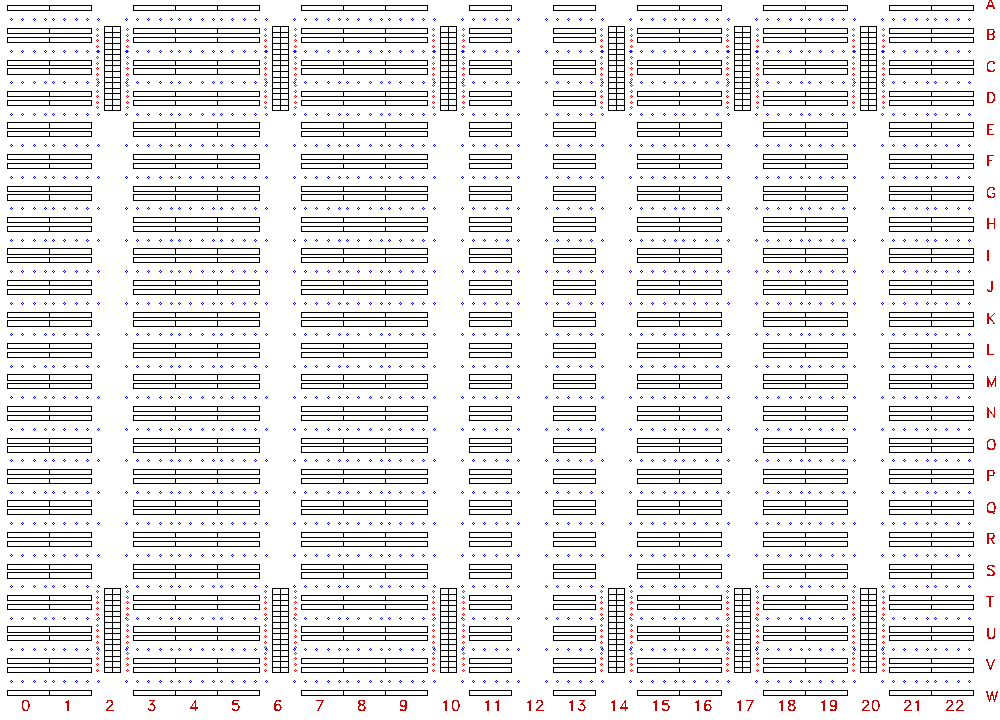

In [ ]:
"""
Отрисовка всех вершин графа

"""

vertexes = empty_canvas.copy()
for v in VERTEX_DICT.values():
    x, y = round(v.x*PIXELS_IN_METER), round(v.y*PIXELS_IN_METER)
    if v.name[0] == 't':
        color = [0,0,255]
    else:
        color = [255,0,0]
    # print(x, y)
    vertexes = cv2.circle(vertexes, [x, y], 1, color, 1,)
cv2_imshow(vertexes)

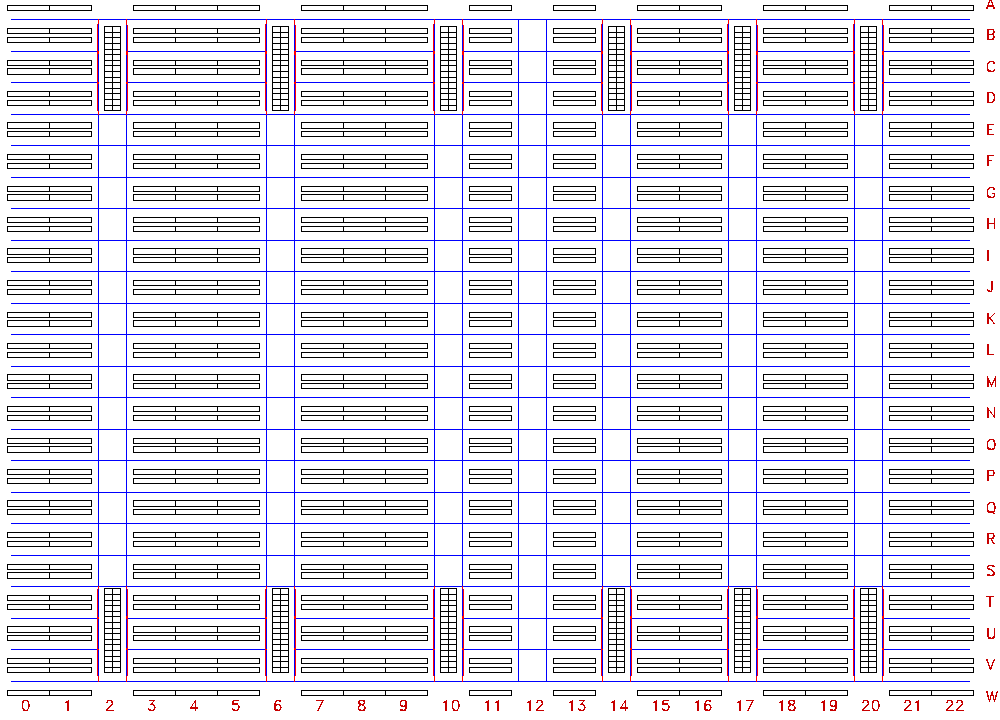

In [ ]:
canvas = empty_canvas.copy()
for edges in GRAPH.edge_dict.values():
    for e in edges:
        
        eu = VERTEX_DICT[e.u]
        ev = VERTEX_DICT[e.v]
        x1 = round(eu.x*PIXELS_IN_METER)
        x2 = round(ev.x*PIXELS_IN_METER)
        y1 = round(eu.y*PIXELS_IN_METER)
        y2 = round(ev.y*PIXELS_IN_METER)

        # print(e)
        # print((x1,y1), (x2,y2))

        if eu.name[0] == 't' or ev.name == 't':
            color = [0,0,255]
        else:
            color = [255,0,0]

        # cv2_imshow(canvas)
        # input()

        canvas = cv2.line(canvas, [x1, y1], [x2, y2], color, 1,)

cv2_imshow(canvas)

In [ ]:
from sortedcontainers import SortedList

ALL_X = set()                       # список всех координат для поиска ближайшей вершины графа
ALL_Y = set()
ALL_XY = []

for value in VERTEX_DICT.values():
    ALL_X.add(value.x)
    ALL_Y.add(value.y)
    ALL_XY.append([value.x, value.y])



ALL_X = SortedList(ALL_X)           # для быстрого поиска индекса заданного элемента в массиве
ALL_Y = SortedList(ALL_Y)

df_XY = pd.DataFrame(columns=['X', *ALL_X], index=['Y', *ALL_Y])

for key, value in VERTEX_DICT.items():
    df_XY[value.x][value.y] = key

df_XY.head(5)


,X,1.6,3.2,4.800000000000001,6.4,7.6,9.2,10.8,12.399999999999999,13.9,...,126,126.1,127.6,129.2,130.79999999999998,132.4,133.6,135.2,136.79999999999998,138.4
Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.75,NaN,B-0(p-0),B-0(p-1),B-0(p-2),B-0(p-3),B-1(p-0),B-1(p-1),B-1(p-2),B-1(p-3),NaN,...,AB-20(R),NaN,B-21(p-0),B-21(p-1),B-21(p-2),B-21(p-3),B-22(p-0),B-22(p-1),B-22(p-2),B-22(p-3)
4.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t2-0,...,NaN,t20-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t2-2,...,NaN,t20-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t2-4,...,NaN,t20-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## DF

In [ ]:
def create_empty_prod_dataframe():
    cols2 = ['Article', 'Vertex', 'Pallet_index', 'Sell_by_date']   # таблица, 
    DF_PROD = pd.DataFrame(columns=cols2)                   # которая будет хранить все товары
    
    return DF_PROD

In [ ]:
def put_product_to_rack(products, sell_by_dates, rack_index, pallet_column, pallet_tier):
    '''
    Помещает товар на стеллаж

    rack_index имеет вид "G-8" для нечётных стеллажей (подъезд с северной стороны) или "G'-8" - для чётных стеллажей (подъезд с южной стороны)
    
    '''
    if type(products) != list:
        products = [products]
    if type(sell_by_dates) != list:
        sell_by_dates = [sell_by_dates]

    prod_list = [Product(p,s) for p,s in zip(products, sell_by_dates)]

    r, c = rack_index.split('-')
    c = int(c)
    rack = DF_RACK[r][c]
    pallet = Pallet(prod_list)

    if DF_PROD.last_valid_index() is None:
        i = 0
    else:
        i = DF_PROD.last_valid_index() + 1
    
    for prod in prod_list:
        prod.index = i
        i += 1

    rack.put_pallet(pallet, column=pallet_column, tier=pallet_tier)



In [ ]:
# Помещаем 2 вида товаров на 1 паллету на стеллаже
DF_PROD = create_empty_prod_dataframe()

put_product_to_rack(['Milk', 'Coffe'], ['01_02_23', '01_09_23'], rack_index='J-5', pallet_column=0, pallet_tier=0)

DF_PROD

,Article,Vertex,Pallet_index,Sell_by_date
0,Milk,J-5(p-0),"(0, 0)",01_02_23
1,Coffe,J-5(p-0),"(0, 0)",01_09_23


In [ ]:
# Добавляем на стеллаж ещё одну паллету с одним товаром

put_product_to_rack('Tea', '01_02_23', rack_index='J-5', pallet_column=2, pallet_tier=0)

DF_PROD

,Article,Vertex,Pallet_index,Sell_by_date
0,Milk,J-5(p-0),"(0, 0)",01_02_23
1,Coffe,J-5(p-0),"(0, 0)",01_09_23
2,Tea,J-5(p-2),"(2, 0)",01_02_23


In [ ]:
# Посмотрим на весь стеллаж

DF_RACK['J'][5].pallets

array([[[Pallet at (0,0)], None, None, None, None],
       [None, None, None, None, None],
       [[Pallet at (2,0)], None, None, None, None],
       [None, None, None, None, None]], dtype=object)

In [ ]:
# Забираем паллету со стеллажа

DF_RACK['J'][5].get_pallet(0,0)

[Pallet at (None,None)]

In [ ]:
# Проверяем, что паллета со стеллажа исчезала

DF_RACK['J'][5].pallets

array([[None, None, None, None, None],
       [None, None, None, None, None],
       [[Pallet at (2,0)], None, None, None, None],
       [None, None, None, None, None]], dtype=object)

In [ ]:
DF_PROD

,Article,Vertex,Pallet_index,Sell_by_date
0,Milk,"Оn going (31.6, 38.75)","(0, 0)",01_02_23
1,Coffe,"Оn going (31.6, 38.75)","(0, 0)",01_09_23
2,Tea,J-5(p-2),"(2, 0)",01_02_23


In [ ]:
cols = ['Article', 'Pallet', 'Tier', 'Sell_by_date']
DF_PROD = pd.DataFrame(columns=cols)

## Поиск

In [ ]:
'''
Классический поиск наименьшего пути по взвешеному графу (алгоритм Дейкстры)
Минус в том, что он не учитывает количество поворотов (только длину пути), а лишние повороты (движение "лесенкой") - это не хорошо

Суть модификации: сохранить все минимальные пути равной длинны, а потом при построении маршрута выбирать тот вариант, который не изменяет направление движения (если это возможно)
'''

# def min_path(path_dict, start, end):
#     if len(path_dict) == 0:
#         return []
#     path = []
#     edge = path_dict[end][0]
#     path.append(edge)
#     while edge.u != start:
#         edge = path_dict[edge.u][0]
#         path.append(edge)
#         orientation = edge.orientation()
#     return list(reversed(path))

# min_path(path_dict, 'TU-14(R)', 'D-3(p-1)')

'\nКлассический поиск наименьшего пути по взвешеному графу (алгоритм Дейкстры)\nМинус в том, что он не учитывает количество поворотов (только длину пути), а лишние повороты (движение "лесенкой") - это не хорошо\n\nСуть модификации: сохранить все минимальные пути равной длинны, а потом при построении маршрута выбирать тот вариант, который не изменяет направление движения (если это возможно)\n'

In [ ]:
def graph_search(g, start):         # сканирует граф 'g'

    first_vertex = g.vertex_dict[start]
    distances = {key: None for key in g.vertex_dict.keys()}
    distances[start] = 0
    path_dict = {}                                                  #
    pq = PriorityQueue()
    pq.push(Node(first_vertex, distance=0))

    while not pq.empty:
        current_node = pq.pop()
        u = current_node.vertex.name        
        dist_u = distances[u]                       # from

        for edge in g.neighbors_for_vertex(u):
            v = edge.v
            dist_v =  distances[v]        # to

            if dist_v and dist_v == dist_u + edge.weight:
                distances[v] = dist_v
                path_dict[v].append(edge)

            if dist_v is None or dist_v > dist_u + edge.weight:         # если расстояние до вершины не определено или найден более короткий путь,
                distances[v] = dist_u + edge.weight                         # то обновляем значение дистанции до вершины
                path_dict[v] = [edge]
                new_vertex = g.vertex_dict[v]
                pq.push(Node(new_vertex, distances[v], prev_node=current_node))
    
    # path_dict['start'] = [edge for edge in g.edge_dict[start]]
    return path_dict


def min_path(path_dict, start, end):        # ищет минимальный муть от start до end
    if len(path_dict) == 0:
        return []
    for edge in path_dict[end]:             # если между конечной и начальной точкой 1 ребро - это и есть весь путь (иначе будет key error)
        if edge.u == start:
            return [edge]
    path = []
    edge = path_dict[end][0]
    orientation = edge.orientation()
    path.append(edge)
    if len(path_dict[edge.u]) == 1:
        while edge.u != start:
            edge = path_dict[edge.u][0]
            path.append(edge)
    else:
        while edge.u != start:
            ed = None
            for e in path_dict[edge.u]:
                if e.orientation() != orientation:
                    pass
                else:
                    ed = e
                    break
            if ed is None:
                edge = path_dict[edge.u][0]
            else:
                edge = ed
            path.append(edge)
            orientation = edge.orientation()

    return list(reversed(path))

path_dict = graph_search(GRAPH, 'U-15(p-1)')
path = min_path(path_dict, 'U-15(p-1)', 'C-5(p-1)')
path_distances = [p.weight for p in path]
path_distances = np.cumsum(path_distances)

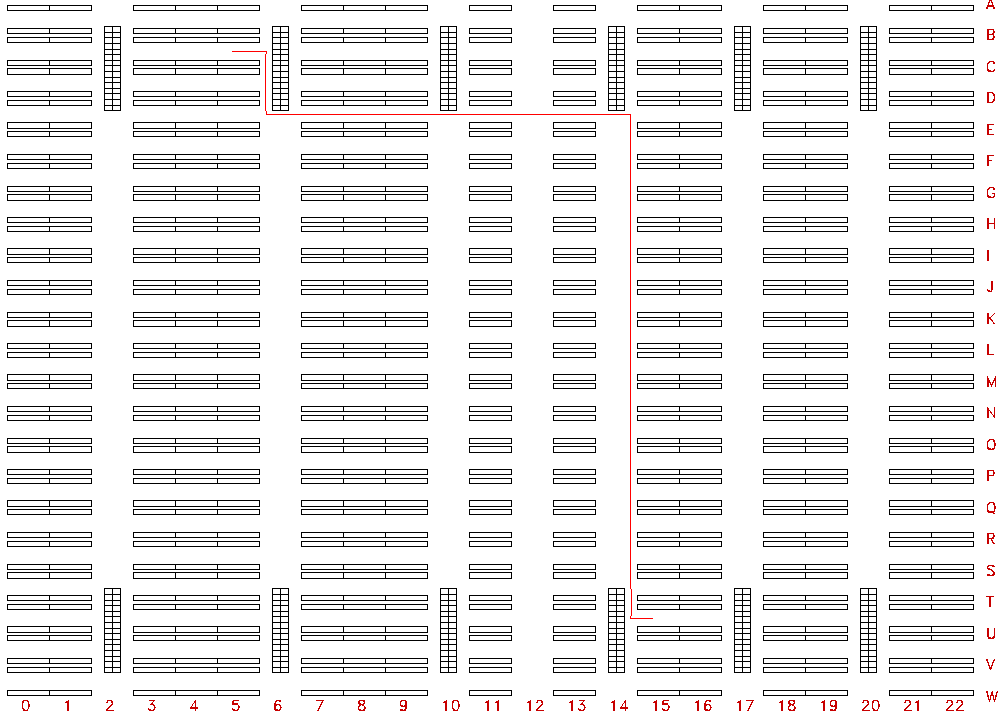

In [ ]:
canvas = empty_canvas.copy()

for point in path:

    P = PIXELS_IN_METER
    u = point.u
    v = point.v
    x1 = round(vertex_dict[u].x*P)
    y1 = round(vertex_dict[u].y*P)
    x2 = round(vertex_dict[v].x*P)
    y2 = round(vertex_dict[v].y*P)

    canvas = cv2.line(canvas, (x1, y1), (x2, y2), (0, 0, 255), 1)
cv2_imshow(canvas)

In [ ]:
canvas_ = canvas.copy()

## Агенты

In [ ]:
class Target():
    def __init__(self, vertex_index, x=None, y=None):
        if vertex_index:
            vertex = vertex_dict[vertex_index]
            x = vertex.x
            y = vertex.y
            self.vertex = vertex

        # self.name = name
        self.x = x
        self.y = y

    def __repr__(self):
        return self.vertex.name

In [ ]:
class Point():
    doing = None
    timer = 0
    main_icon_path = None
    extra_icon_path = None
    moving_pause = False

    def __init__(self, name, vertex, speed, graph, x=None, y=None):
        if vertex:
            x = vertex_dict[vertex].x
            y = vertex_dict[vertex].y

        if x and y and vertex is None:
           vertex = self.find_nearest_vertex(x, y)

        self.name = name
        self.step_length = speed * SECONDS_IN_FRAME
        self.graph = GRAPH
        self.x = x
        self.y = y
        self.vertex = vertex
        self.target = None
        self.offset = 0
        self.path = []
        self.icon_w = 16
        self.icon_h = 16
        self.icon_main = np.full((self.icon_w,self.icon_h,3), fill_value=(np.array([0, 0, 255])))
        self.icon = self.icon_main
        self.pallet = None

    def take_pallet(self, pallet):
        if not(self.pallet):
            self.pallet = pallet
        else:
            print(f'{self.name} already has a {self.pallet}')
            ERRORS.loc[len(ERRORS)] = [f'{self.name} already has a {self.pallet}', f'vertex = {self.vertex}']

    def give_pallet(self):
        if not(self.pallet is None):
            pal = self.pallet
            self.pallet = None
            return pal
        else:
            print(f'{self.name} has no pallet')
            ERRORS.loc[len(ERRORS)] = [f'{self.name} has no pallet', f'vertex = {self.vertex}']

    def direction(self):            # по идее не нужно, но пусть будет
        if self.target is None:
            return (0, 0)
        else:
            if self.x == self.target.x:
                dir_x = 0

            elif self.x < self.target.x:
                dir_x = 1

            elif self.x > self.target.x:
                dir_x = -1

            if self.y == self.target.y:
                dir_y = 0

            elif self.y < self.target.y:
                dir_y = 1

            elif self.y > self.target.y:
                dir_y = -1    
        return dir_x, dir_y  

    def graph_search(self):         # сканирует граф 'g'
        start = self.vertex
        g = self.graph
        first_vertex = g.vertex_dict[start]
        distances = {key: None for key in g.vertex_dict.keys()}
        distances[start] = 0
        path_dict = {}                                                  #
        pq = PriorityQueue()
        pq.push(Node(first_vertex, distance=0))

        while not pq.empty:
            current_node = pq.pop()
            u = current_node.vertex.name        
            dist_u = distances[u]                       # from

            for edge in g.neighbors_for_vertex(u):
                v = edge.v
                dist_v =  distances[v]        # to

                if dist_v and dist_v == dist_u + edge.weight:
                    distances[v] = dist_v
                    path_dict[v].append(edge)

                if dist_v is None or dist_v > dist_u + edge.weight:         # если расстояние до вершины не определено или найден более короткий путь,
                    distances[v] = dist_u + edge.weight                         # то обновляем значение дистанции до вершины
                    path_dict[v] = [edge]
                    new_vertex = g.vertex_dict[v]
                    pq.push(Node(new_vertex, distances[v], prev_node=current_node))
        return path_dict


    def find_min_path(self, start, end):        # ищет минимальный муть от start до end
        path_dict = self.graph_search()

        if len(path_dict) == 0:
            return []

        for edge in path_dict[end]:
            if edge.u == start:
                self.path = [edge]
                return
        path = []
        edge = path_dict[end][0]
        orientation = edge.orientation()
        path.append(edge)
        if len(path_dict[edge.u]) == 1:
            while edge.u != start:
                edge = path_dict[edge.u][0]
                path.append(edge)
        else:
            while edge.u != start:
                ed = None
                for e in path_dict[edge.u]:
                    if e.orientation() == 'o':
                        ed = e
                        break
                    elif e.orientation() != orientation:
                        pass
                    else:
                        ed = e
                        break
                if ed is None:
                    edge = path_dict[edge.u][0]
                else:
                    edge = ed
                path.append(edge)
                orientation = edge.orientation()
        self.path = deepcopy(list(reversed(path)))
        path_distances = [p.weight for p in path]
        self.path_distances = list(np.cumsum(path_distances))


    def trunc_step(self):
        i = False
        dist = 0
        edge = self.path[0].weight
        while dist + edge < self.step_length:
            dist += edge
            i = True
            vertex_index = self.path.pop(0).v
            vertex = vertex_dict[vertex_index]
            if self.path:
                edge = self.path[0].weight
            else:
                self.vertex = vertex.name
                self.x = self.graph.vertex_dict[self.vertex].x
                self.y = self.graph.vertex_dict[self.vertex].y
                # self.target = None
                self.doing = None
                return 0
        if i:
            self.x = vertex.x
            self.y = vertex.y
            self.temp = vertex
            if self.path:
                next_vertex_index = self.path[0].v
                self.target = Target(next_vertex_index)

        return self.step_length - dist


    def move_XY(self, final_edge=False):
        step = self.trunc_step()
        a = self.target.x - self.x
        b = self.target.y - self.y
        if not(a) and not(b):
            # print('NO a, b')
            return
        distanse = (a**2 + b**2)**0.5

        if abs(b) < 0.001:
            dx = step * self.direction()[0]
            dy = 0
        elif abs(a) < 0.001:
            dx = 0
            dy = step * self.direction()[1]
        else:
            dx = step / ((b / a)**2 + 1)**0.5 * self.direction()[0]
            dy = step / ((a / b)**2 + 1)**0.5 * self.direction()[1]

        offset = (dx**2 + dy**2)**0.5
        if self.path:
            self.path[0].weight = distanse - offset
        self.x += dx
        self.y += dy

    def move_across_path(self):
        if self.path:
            self.move_XY()
        else:
            # self.target = None
            self.doing = None
            print('Приехали')


    def go(self, target_vertex_key):

        if not(self.vertex ):
            VERTEX_DICT['temp'] = Vertex('temp', self.x, self.y)                # ИСПРАВИТЬ ДУБЛИРОВАНИЕ!
            self.graph.vertex_dict['temp'] = Vertex('temp', self.x, self.y)
            self.graph.edge_dict['temp'] = []
            u =self.graph.vertex_dict['temp'].name
            v, distance = self.find_nearest_vertex()
            self.graph.add_edge_by_indice(u, v, weight=distance)
            self.vertex = 'temp'

        if self.vertex == target_vertex_key:
            print('Already in point')
            return
        self.find_min_path(self.vertex, target_vertex_key)
        self.vertex = None
        self.target = Target(self.path[0].v)
        self.move_across_path()
        self.doing = 'go'

    def jump(self, del_x, del_y):
        self.x += del_x
        self.y += del_y

    def do_something(self, time, doing='doing_something'):
        if self.doing == 'go':
            self.doing = 'MOVING PAUSE: ' + doing
            self.moving_pause = True

        if time > 0.5:
            self.doing = doing
            self.timer = time // SECONDS_IN_FRAME
            self.set_icon_timer()
            self.increase_edge_weight(5 * time)


    def increase_edge_weight(self, delta):
        for edge in self.graph.edge_dict[self.vertex]:
            edge.weight += delta

    def restore_edge_weight(self):
        for edge in self.graph.edge_dict[self.vertex]:
            edge.weight = edge._weight

    def busy(self):
        return self.doing
    
    def set_icon_timer(self):
        empty_icon = np.ones((self.icon_h, self.icon_w, 3)) * 255
        self.icon = cv2.rectangle(empty_icon, (0,0), (self.icon_h, self.icon_w-1), (0,125,255), 2)
        self.icon = cv2.putText(self.icon, str(self.timer), (1,10), cv2.FONT_HERSHEY_DUPLEX, 0.3, (0,0,0), 1)

    def continue_(self):
        if self.doing == 'go':
            if self.path:
                self.move_across_path()

        elif self.doing:
            self.timer -= 1
            if self.timer <= 0:
                if self.moving_pause:
                    self.icon = self.icon_main
                    self.moving_pause = False
                    self.doing = 'go'
                else:
                    self.doing = None
                    self.icon = self.icon_main
                    self.restore_edge_weight()
            else:
                 self.set_icon_timer()
        

    def find_nearest_vertex(self):
        tree = KDTree(ALL_XY)
        dist, ind = tree.query([[self.x, self.y]])
        x = ALL_XY[ind[0,0]][0]
        y = ALL_XY[ind[0,0]][1]
        return df_XY[x][y], dist[0,0]


    def closure(self):
        pass

    def find_new_path(self):
        pass

x = Point('a', speed=2, vertex="A'-0(p-0)", graph=GRAPH)

In [ ]:
class Truck(Point):
    def __init__(self, name, vertex, speed, graph, x=None, y=None):
        Point.__init__(self, name, vertex, speed, graph, x=None, y=None)
        # self.icon_main = cv2.imread("truck.jpg")
        self.icon_w = 30
        self.icon_h = 20
        # self.icon_main = cv2.resize(self.icon_main, (self.icon_w, self.icon_h))
        # self.icon = self.icon_main
        # self.is_empty = is_empty
        self.icon = np.full((10,10,3), fill_value=(np.array([255, 0, 0])))
        self.icon_main = self.icon
        self.step_length = TRUCK_SPEED * SECONDS_IN_FRAME

truck = Truck('truck', vertex="B-15(p-3)", speed=FORKLIFT_SPEED, graph=GRAPH)
cv2_imshow(truck.icon)

In [ ]:
class Stacker(Point):           # Штабелёр
    def __init__(self, name, vertex, speed, graph, x=None, y=None):
        Point.__init__(self, name, vertex, speed, graph, x=None, y=None)
        # self.icon_main = cv2.imread("stacker.jpg")
        self.icon_w = 20
        self.icon_h = 30
        # self.icon_main = cv2.resize(self.icon_main, (self.icon_w, self.icon_h))
        # self.icon = self.icon_main
        self.icon = np.full((10,10,3), fill_value=(np.array([0, 255, 0])))
        self.icon_main = self.icon
        self.step_length = STACKER_SPEED * SECONDS_IN_FRAME

staker = Stacker('staker', vertex="R-15(p-3)", speed=FORKLIFT_SPEED, graph=GRAPH)
cv2_imshow(staker.icon)

In [ ]:
FORKLIFT_SPEED = 1
SECONDS_IN_FRAME = 1
DF_RACK = create_empty_rack_dataframe()
create_empty_warehouse([])

In [ ]:
class Forklift(Point):           # Вилочный погрузчик
    def __init__(self, name, vertex, speed, graph, x=None, y=None):
        Point.__init__(self, name, vertex, speed, graph, x=None, y=None)
        # self.icon_empty = cv2.imread("forklift_empty.jpg")
        # self.icon_full = cv2.imread("forklift_full.jpg")
        self.icon_w = 10
        self.icon_h = 10
        # self.icon_empty = cv2.resize(self.icon_empty, (self.icon_w, self.icon_h))
        # self.icon_full = cv2.resize(self.icon_full, (self.icon_w, self.icon_h))
        # self.icon_main = self.icon_empty
        # self.icon = self.icon_empty
        self.icon = np.full((self.icon_h,self.icon_w,3), fill_value=(np.array([0, 0, 255])))
        self.icon_main = self.icon

forklift = Forklift('Forklift', vertex="U-15(p-3)", speed=FORKLIFT_SPEED, graph=GRAPH)
forklift_shape = forklift.icon.shape
cv2_imshow(forklift.icon)

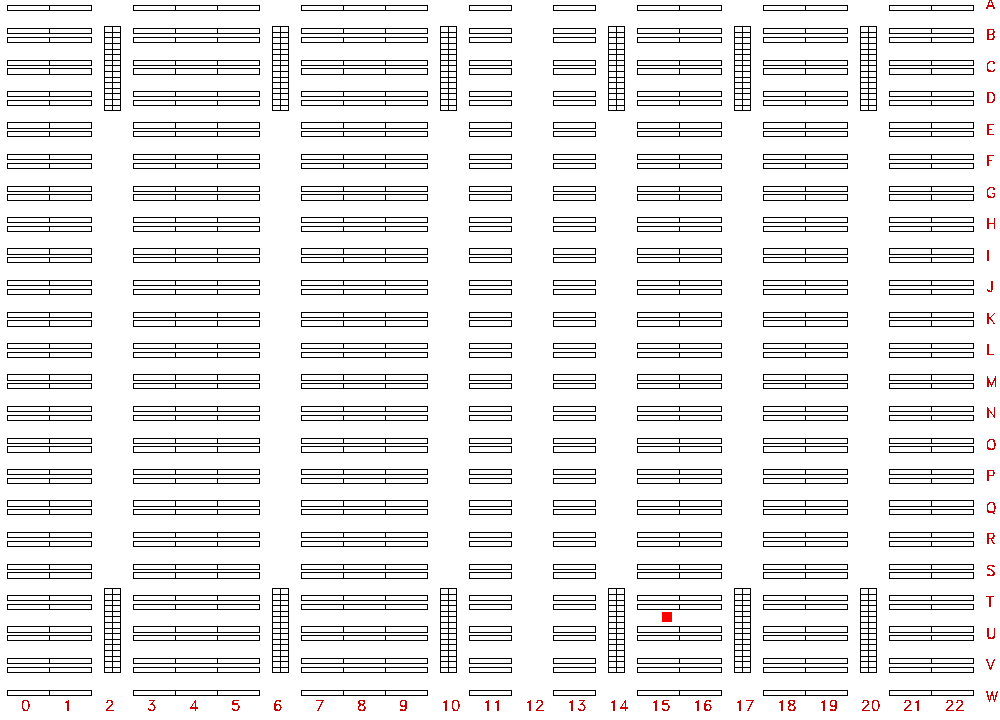

In [ ]:
canvas = empty_canvas.copy()
forklift.go("U-15(p-1)")

x, y = int(forklift.x * PIXELS_IN_METER), int(forklift.y * PIXELS_IN_METER)
canvas[y - + forklift_shape[0]//2 : y + forklift_shape[0]//2, x - forklift_shape[1]//2 : x + forklift_shape[1]//2] = forklift.icon
cv2_imshow(canvas)

In [ ]:
forklift.go("t6-35")

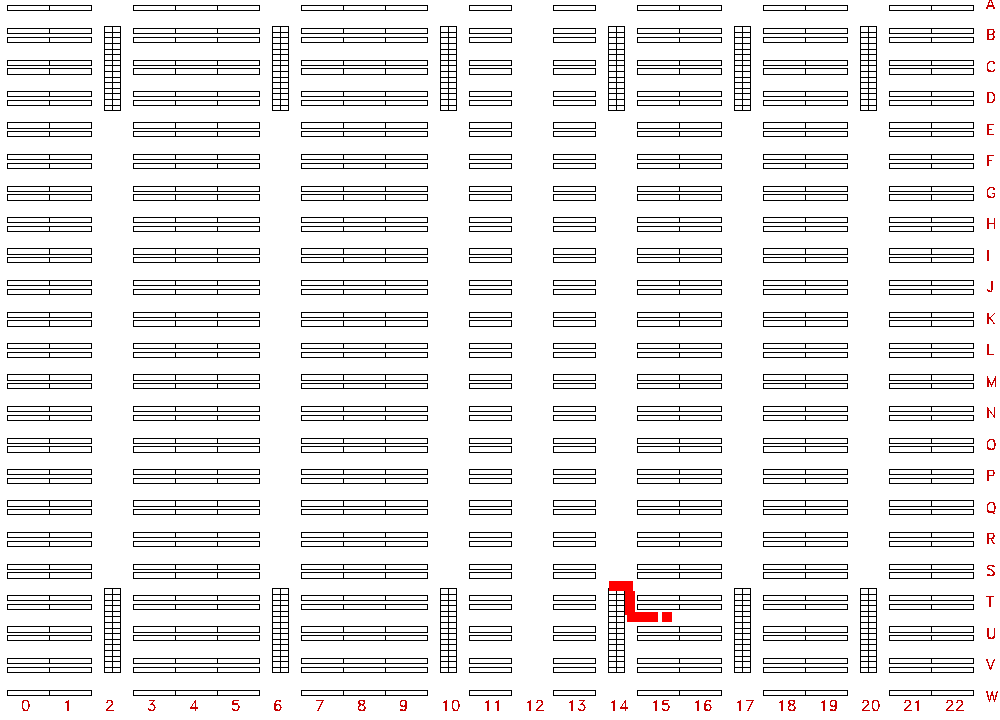

In [ ]:
for i in range(10):
    # canvas = canvas_.copy()
    forklift.continue_()
    x, y = int(forklift.x * PIXELS_IN_METER), int(forklift.y * PIXELS_IN_METER)
    canvas[y - + forklift_shape[0]//2 : y + forklift_shape[0]//2, x - forklift_shape[1]//2 : x + forklift_shape[1]//2] = forklift.icon
cv2_imshow(canvas)

In [ ]:
forklift.path

[Edge [ST-14(R) -> ST-14(L)] (w=1.799999999999983),
 Edge [ST-14(L) -> T-13(p-3)] (w=1.6),
 Edge [T-13(p-3) -> T-13(p-2)] (w=1.6),
 Edge [T-13(p-2) -> T-13(p-1)] (w=1.6),
 Edge [T-13(p-1) -> T-13(p-0)] (w=1.6),
 Edge [T-13(p-0) -> ST-12(R)] (w=1.6),
 Edge [ST-12(R) -> ST-12(L)] (w=3),
 Edge [ST-12(L) -> T-11(p-3)] (w=1.6),
 Edge [T-11(p-3) -> T-11(p-2)] (w=1.6),
 Edge [T-11(p-2) -> T-11(p-1)] (w=1.6),
 Edge [T-11(p-1) -> T-11(p-0)] (w=1.6),
 Edge [T-11(p-0) -> ST-10(R)] (w=1.6),
 Edge [ST-10(R) -> ST-10(L)] (w=3),
 Edge [ST-10(L) -> S'-9(p-3)] (w=1.6),
 Edge [S'-9(p-3) -> S'-9(p-2)] (w=1.6),
 Edge [S'-9(p-2) -> S'-9(p-1)] (w=1.6),
 Edge [S'-9(p-1) -> S'-9(p-0)] (w=1.6),
 Edge [S'-9(p-0) -> S'-8(p-3)] (w=1.2),
 Edge [S'-8(p-3) -> S'-8(p-2)] (w=1.6),
 Edge [S'-8(p-2) -> S'-8(p-1)] (w=1.6),
 Edge [S'-8(p-1) -> S'-8(p-0)] (w=1.6),
 Edge [S'-8(p-0) -> S'-7(p-3)] (w=1.2),
 Edge [S'-7(p-3) -> S'-7(p-2)] (w=1.6),
 Edge [S'-7(p-2) -> S'-7(p-1)] (w=1.6),
 Edge [S'-7(p-1) -> S'-7(p-0)] (w=1.6),
 

In [ ]:
forklift.vertex

In [ ]:
forklift.x

87.79999999999998

In [ ]:
vertex_dict['U-15(p-1)'].x

93.19999999999999

In [ ]:
def render(agents=[]):
    canvas = empty_canvas.copy()
    for agent in agents:
        agent_shape = agent.icon.shape
        x, y = int(agent.x * PIXELS_IN_METER), int(agent.y * PIXELS_IN_METER)
        canvas[y - + agent_shape[0]//2 : y + agent_shape[0]//2, x - agent_shape[1]//2 : x + agent_shape[1]//2] = agent.icon
    cv2_imshow(canvas)

# Эксплуатация

Глобальные переменные и функции

In [ ]:
PIXELS_IN_METER = 7
SECONDS_IN_FRAME = 1

ERRORS = pd.DataFrame(columns=['Error', 'Info'])

In [ ]:
row_names
rack_column_names

In [ ]:
GRAPH       # Не экранировать!
DF_PROD
DF_RACK
ALL_X
ALL_Y
ALL_XY
df_XY

Действия

In [ ]:
agent_1 = Point('Petrovich', vertex="FG-10(R)", speed=2, graph=GRAPH)

agent_1.icon_main = np.full((10,10,3), fill_value=(np.array([255, 0, 255])))
agent_1.icon = agent_1.icon_main
cv2_imshow(agent_1.icon)

In [ ]:
agent_2 = Point('Mihalych', "S-5(p-2)", speed=2, graph=GRAPH)          # Создаём агента

agent_2.icon_main = np.full((10,10,3), fill_value=(np.array([0, 0, 255])))
agent_2.icon = agent_2.icon_main
cv2_imshow(agent_2.icon)

In [ ]:
agents = [agent_1, agent_2]                                     # Список агентов передаётся функции create_empty_warehouse()

custom_df_name = DF_RACK = create_empty_rack_dataframe()        # создаёт пустую таблицу для хранения стеллажей

DF_PROD = create_empty_prod_dataframe()                         # Создаёт пустую таблицу для хранения товаров

create_empty_warehouse(agents, create_df_rack=False)                                        # Создаёт объекты стеллажей (заносит в таблицу) и соединяет граф

put_product_to_rack('Milk', '01.01.23', rack_index="B-0", pallet_column=3, pallet_tier=1)       # Функция для заполнения стеллажа
put_product_to_rack('Tea', '01.01.23', rack_index="B-0", pallet_column=0, pallet_tier=1)

In [ ]:
custom_df_name.head(2)

,A',B,B',C,C',D,D',E,E',F,...,U',V,V',W,t2,t6,t10,t14,t17,t20
0,"Rack A'-0 at (0.1, 0.1)","Rack B-0 at (0.1, 0.6)","Rack B'-0 at (0.1, 0.8)","Rack C-0 at (0.1, 1.2)","Rack C'-0 at (0.1, 1.4)","Rack D-0 at (0.1, 1.9)","Rack D'-0 at (0.1, 2.0)","Rack E-0 at (0.1, 2.5)","Rack E'-0 at (0.1, 2.7)","Rack F-0 at (0.1, 3.1)",...,"Rack U'-0 at (0.1, 13.0)","Rack V-0 at (0.1, 13.4)","Rack V'-0 at (0.1, 13.6)","Rack W-0 at (0.1, 14.1)",Tamp Rack 2-0,Tamp Rack 6-0,Tamp Rack 10-0,Tamp Rack 14-0,Tamp Rack 17-0,Tamp Rack 20-0
1,"Rack A'-1 at (1.0, 0.1)","Rack B-1 at (1.0, 0.6)","Rack B'-1 at (1.0, 0.8)","Rack C-1 at (1.0, 1.2)","Rack C'-1 at (1.0, 1.4)","Rack D-1 at (1.0, 1.9)","Rack D'-1 at (1.0, 2.0)","Rack E-1 at (1.0, 2.5)","Rack E'-1 at (1.0, 2.7)","Rack F-1 at (1.0, 3.1)",...,"Rack U'-1 at (1.0, 13.0)","Rack V-1 at (1.0, 13.4)","Rack V'-1 at (1.0, 13.6)","Rack W-1 at (1.0, 14.1)",Tamp Rack 2-1,Tamp Rack 6-1,Tamp Rack 10-1,Tamp Rack 14-1,Tamp Rack 17-1,Tamp Rack 20-1


In [ ]:
DF_RACK["B"][0].pallets      # Список паллет стеллажа

array([[None, [Pallet at (0,1)], None, None, None],
       [None, None, None, None, None],
       [None, None, None, None, None],
       [None, [Pallet at (3,1)], None, None, None]], dtype=object)

In [ ]:
DF_PROD

,Article,Vertex,Pallet_index,Sell_by_date
0,Milk,B-0(p-3),"(3, 1)",01.01.23
1,Tea,B-0(p-0),"(0, 1)",01.01.23


In [ ]:
col, tier = DF_PROD.loc[1].Pallet_index             # получаем индекс паллеты для нужного нам товара

pallet = DF_RACK["B"][0].get_pallet(col, tier)        # снимаем паллету со стеллажа

In [ ]:
agent_1.take_pallet(pallet)                         # отдаём агенту

agent_1.pallet

[Pallet at (None,None)]

In [ ]:
DF_RACK["B"][0].pallets                 # проверяем стеллаж

array([[None, None, None, None, None],
       [None, None, None, None, None],
       [None, None, None, None, None],
       [None, [Pallet at (3,1)], None, None, None]], dtype=object)

In [ ]:
agent_1.do_something(2, 'talk')
print(agent_1.busy())
cv2_imshow(agent_1.icon)

talk


In [ ]:
agent_1.continue_()
cv2_imshow(agent_1.icon)

In [ ]:
agent_1.continue_()
cv2_imshow(agent_1.icon)

In [ ]:
print(agent_1.busy())                   # Проверка, чем занят агент

vertex = DF_PROD.loc[0].Vertex          # Получение вершины графа соответствующей нужному товару
agent_1.go(vertex)                        # Направить агента в точку назначения
agent_1.go('B-0(p-3)')

print(agent_1.busy())                   

None
go


In [ ]:
pallet = agent_2.give_pallet() 

Mihalych has no pallet


In [ ]:
pallet = agent_1.give_pallet()          # Забрать паллету у агента

DF_RACK['t6'][12].put_pallet(pallet)        # Положить на стеллаж временного хранения

DF_RACK['t6'][12].pallet

[Pallet at (None,None)]

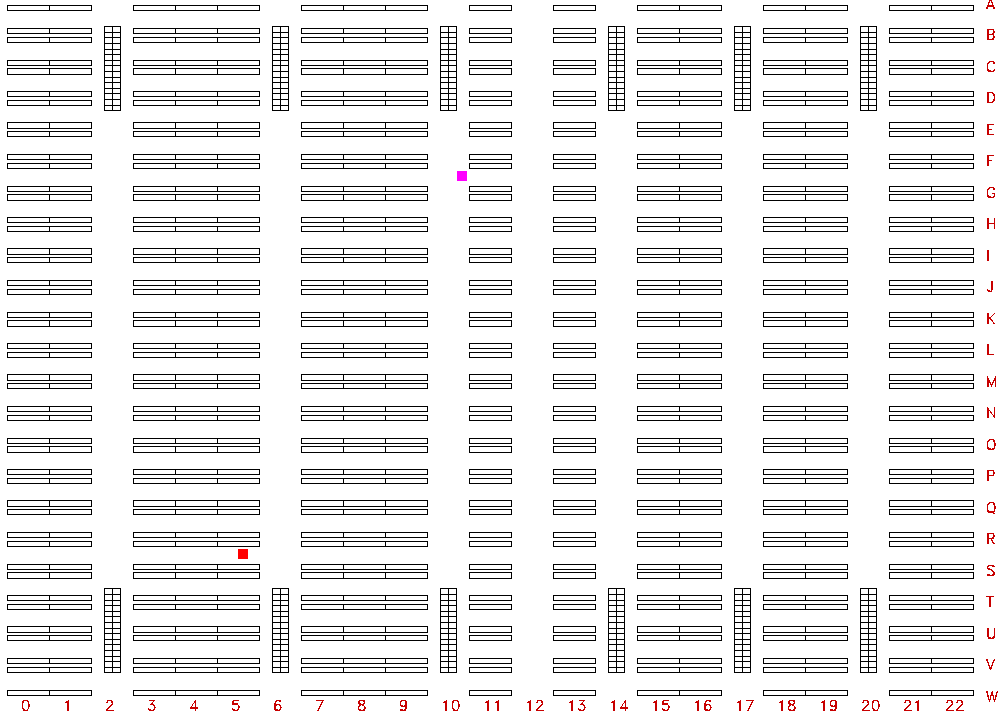

In [ ]:
render(agents)                         # отрисовка агентов

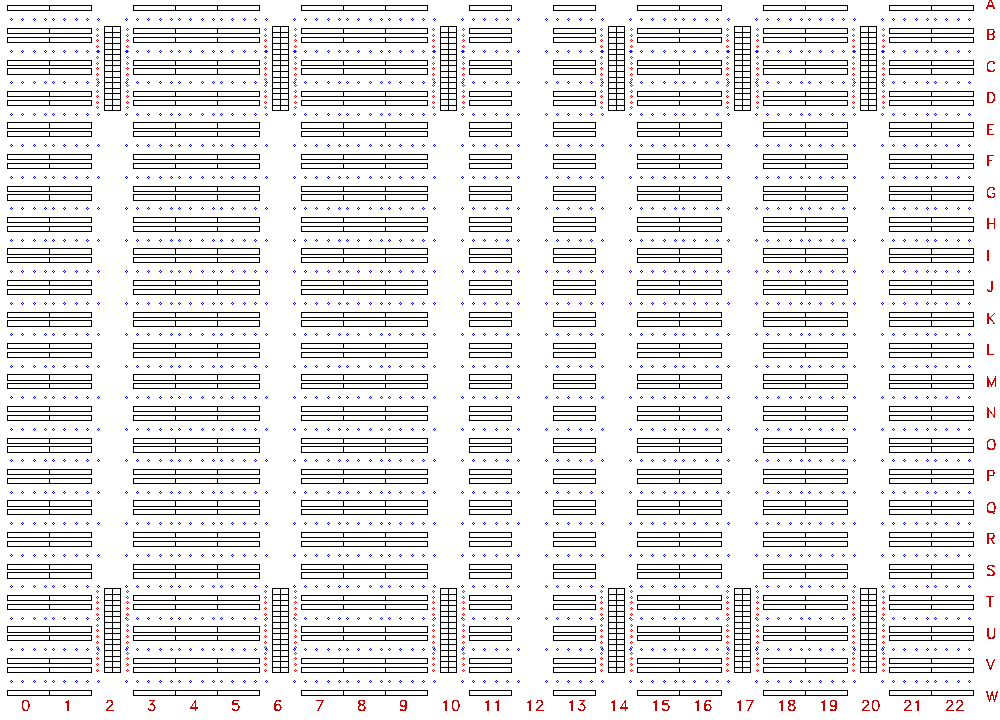

In [ ]:
cv2_imshow(vertexes)

In [ ]:
"A'-0(p-3)", "B-0(p-3)", "AB-2(L)", "t2-59"

In [ ]:
sun_is_shining = True

while sun_is_shining:
    for agent in agents:
        agent.continue_()

    sun_is_shining = False
    